# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Applied\ DL\ Music/

/content/drive/.shortcut-targets-by-id/1WiLGkdpFT7wl_snghM9azz5CzfomSCrF/Applied DL Music


In [51]:
!pip install pypianoroll

     |████████████████████████████████| 5.6 MB 5.8 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=a68bf2662feac550bcf12e42d303f583eab7c760921a6f44db4203b626e833d4
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


# Load data

In [3]:
import pickle as pkl
import numpy as np

with open('dataset_multracks.pkl', 'rb') as f:

  songs = pkl.load(f) # 22 secondes
f.close()


# AE

In [24]:
import keras
import tensorflow as tf
from keras import Model
from keras import layers
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Dropout, Reshape, Flatten, Concatenate
from tensorflow.keras.backend import random_normal, squeeze     

In [5]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x

In [6]:
WINDOW = 256
MAX_VELOCITY = 127

In [7]:
class AE(Model):

  def __init__(self, latent_space=128, window=WINDOW):
    super().__init__()

    ins = Input(shape=(window, 128, 1))
    x = Conv2D(1024, kernel_size=(4, 4), strides=(4, 4), activation='relu')(ins)
    x = Conv2D(512, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Conv2D(256, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Flatten()(x)

    z = Dense(latent_space)(x)

    x = Dense(256, activation='relu')(z)
    x = Reshape((1, 1, 256))(x)
    x = Conv2DTranspose(256, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Conv2DTranspose(512, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    x = Conv2DTranspose(1024, kernel_size=(4, 4), strides=(4, 4), activation='relu')(x)
    outs = Conv2DTranspose(1, kernel_size=(4, 2), strides=(4, 2), activation='relu')(x)

    self.encoder = Model(ins, z, name='encoder')
    self.decoder = Model(z, outs, name='decoder')

    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="Reconstruction_loss"
    )
  
  def summary(self):

    self.encoder.summary()
    self.decoder.summary()
  
  def call(self, x):

    z = self.encoder(x)
    x = self.decoder(z)

    return x

  @property
  def metrics(self):
      return [
          self.reconstruction_loss_tracker
      ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    (data - reconstruction) ** 2, axis=(1, 2)
                )
            )
    grads = tape.gradient(reconstruction_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    return {
        "Reconstruction_loss": self.reconstruction_loss_tracker.result()
    }

def load_ae(instrument: str):

  model = AE()
  model.built = True
  print('loading model {}_ae ...'.format(instrument))
  model.load_weights('models/{}_ae.hdf5'.format(instrument))
  print('succesfully loaded model !')

  return model

# Preprocessing

In [8]:
from tqdm.notebook import tqdm_notebook

def build_melody_dataset(instrument: str, latent_space=128):

  if instrument == 'piano':

    x = np.zeros((58933, latent_space), dtype=np.float16)
    y = np.zeros((58933, latent_space), dtype=np.float16)
  
  elif instrument == 'guitar':

    x_t = np.zeros((14095, latent_space), dtype=np.float16)
    x_p = np.zeros((14095, latent_space), dtype=np.float16)
    y = np.zeros((14095, latent_space), dtype=np.float16)

  elif instrument == 'bass':

    x_t = np.zeros((36651, latent_space), dtype=np.float16)
    x_p = np.zeros((36651, latent_space), dtype=np.float16)
    y = np.zeros((36651, latent_space), dtype=np.float16)

  elif instrument == 'strings':

    x_t = np.zeros((17819, latent_space), dtype=np.float16)
    x_p = np.zeros((17819, latent_space), dtype=np.float16)
    y = np.zeros((17819, latent_space), dtype=np.float16)

  elif instrument == 'drums':

    x_t = np.zeros((31166, latent_space), dtype=np.float16)
    x_p = np.zeros((31166, latent_space), dtype=np.float16)
    y = np.zeros((31166, latent_space), dtype=np.float16)

  if instrument != 'piano':

    ae_piano = load_ae('piano')
    ae_instru = load_ae(instrument)
    index = 0

    for song in tqdm_notebook(songs):

      t = song[instrument]

      if t is not None:

        t = np.expand_dims(t, axis=-1)
        p = np.expand_dims(song['piano'], axis=-1)
      
        i = 2 * WINDOW
        segment_t0 = []
        segment_t1 = []
        segment_p1 = []
        last_index = index

        while i < t.shape[0]:

          segment_t0.append(t[i - 2 * WINDOW: i - WINDOW, :, :])
          segment_t1.append(t[i - WINDOW: i, :, :])
          segment_p1.append(p[i - WINDOW: i, :, :])

          index += 1
          i += WINDOW

        segment_t0 = np.array(segment_t0, dtype=np.float16)
        segment_t1 = np.array(segment_t1, dtype=np.float16)
        segment_p1 = np.array(segment_p1, dtype=np.float16)

        x_t[last_index: index, :] = ae_instru.encoder.predict(segment_t0 / MAX_VELOCITY)
        x_p[last_index: index, :] = ae_piano.encoder.predict(segment_p1 / MAX_VELOCITY)
        y[last_index: index, :] = ae_instru.encoder.predict(segment_t1 / MAX_VELOCITY)

    print('saving datas at latent_vectors_{}.pkl ...'.format(instrument))
    with open('latent_vectors_{}.pkl'.format(instrument), 'wb') as f:

      pkl.dump(([x_t, x_p], y), f)
    f.close()
    print('succesfully saved datas !')

  else:

    ae_piano = load_ae('piano')
    index = 0

    for song in tqdm_notebook(songs):

      p = np.expand_dims(song['piano'], axis=-1)
    
      i = 2 * WINDOW
      last_index = index
      segment_t0 = []
      segment_t1 = []

      while i < p.shape[0]:

        segment_t0.append(p[i - 2 * WINDOW: i - WINDOW, :, :])
        segment_t1.append(p[i - WINDOW: i, :, :])

        index += 1
        i += WINDOW

      segment_t0 = np.array(segment_t0, dtype=np.float16)
      segment_t1 = np.array(segment_t1, dtype=np.float16)

      x[last_index: index, :] = ae_piano.encoder.predict(segment_t0 / MAX_VELOCITY)
      y[last_index: index, :] = ae_piano.encoder.predict(segment_t1 / MAX_VELOCITY)
      
    print('saving datas at latent_vectors_{}.pkl ...'.format(instrument))
    with open('latent_vectors_{}.pkl'.format(instrument), 'wb') as f:

      pkl.dump((x, y), f)
    f.close()
    print('succesfully saved datas !')

In [9]:
build_melody_dataset('piano')
build_melody_dataset('guitar')
build_melody_dataset('bass')
build_melody_dataset('strings')
build_melody_dataset('drums')

loading model piano_ae ...
succesfully loaded model !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving datas at latent_vectors_piano.pkl ...
succesfully saved datas !
loading model piano_ae ...
succesfully loaded model !
loading model guitar_ae ...
succesfully loaded model !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving datas at latent_vectors_guitar.pkl ...
succesfully saved datas !
loading model piano_ae ...
succesfully loaded model !
loading model bass_ae ...
succesfully loaded model !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving datas at latent_vectors_bass.pkl ...
succesfully saved datas !
loading model piano_ae ...
succesfully loaded model !
loading model strings_ae ...
succesfully loaded model !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving datas at latent_vectors_strings.pkl ...
succesfully saved datas !
loading model piano_ae ...
succesfully loaded model !
loading model drums_ae ...
succesfully loaded model !


  0%|          | 0/1607 [00:00<?, ?it/s]

saving datas at latent_vectors_drums.pkl ...
succesfully saved datas !


# latent vectors viz

In [44]:
# merge datas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

instruments = ['piano', 'guitar', 'bass', 'strings', 'drums']

latent_vectors = {instrument: None for instrument in instruments}

for instrument in instruments:

  with open('latent_vectors_{}.pkl'.format(instrument), 'rb') as f:

    _, y = pkl.load(f)

  f.close()

  labels = ['component_{}'.format(i) for i in range(128)] * y.shape[0]
  vectors = []
  for i in range(y.shape[0]):
    vectors += [i] * 128
  latent_vectors[instrument] = pd.DataFrame(zip(np.reshape(y, y.shape[0] * 128), labels, vectors), columns=['latent space', 'component', 'vector'])
  print('{} shape : {}'.format(instrument, latent_vectors[instrument].shape))

piano shape : (7543424, 3)
guitar shape : (1804160, 3)
bass shape : (4691328, 3)
strings shape : (2280832, 3)
drums shape : (3989248, 3)


In [45]:
latent_vectors['piano'].head()

,latent space,component,vector
0,-0.202026,component_0,0
1,0.054932,component_1,0
2,0.022949,component_2,0
3,-0.003492,component_3,0
4,0.027420,component_4,0


piano :



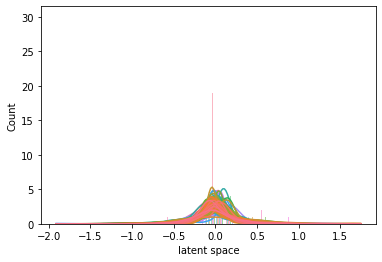

Description : 
count    7.543424e+06
mean    -4.346371e-04
std      0.000000e+00
min     -2.017578e+00
25%     -9.826660e-02
50%     -6.446838e-03
75%      9.033203e-02
max      3.302734e+00
Name: latent space, dtype: float64
guitar :



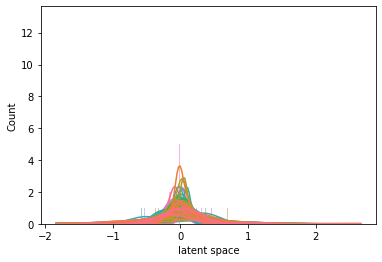

Description : 
count    1.804160e+06
mean     3.201962e-04
std      0.000000e+00
min     -4.281250e+00
25%     -1.182251e-01
50%     -1.750946e-03
75%      1.217041e-01
max      3.529297e+00
Name: latent space, dtype: float64
bass :



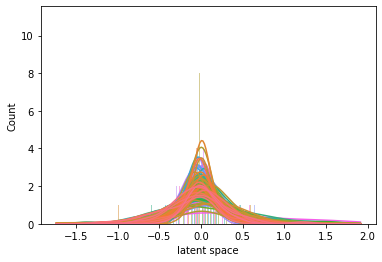

Description : 
count    4.691328e+06
mean     2.424240e-03
std      0.000000e+00
min     -2.759766e+00
25%     -1.398926e-01
50%     -2.582550e-03
75%      1.422119e-01
max      2.671875e+00
Name: latent space, dtype: float64
strings :



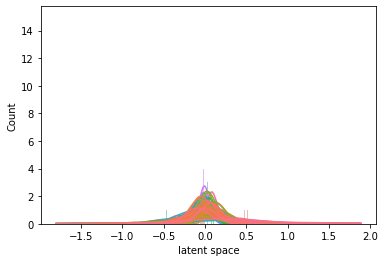

Description : 
count    2.280832e+06
mean     3.774643e-03
std      0.000000e+00
min     -5.085938e+00
25%     -8.013916e-02
50%      2.275467e-03
75%      9.295654e-02
max      4.761719e+00
Name: latent space, dtype: float64
drums :



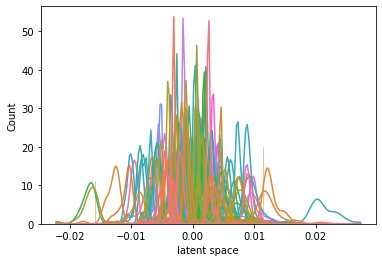

Description : 
count    3.989248e+06
mean     8.529425e-05
std      5.939484e-03
min     -4.418945e-02
25%     -3.347397e-03
50%     -8.547306e-05
75%      3.845215e-03
max      5.923462e-02
Name: latent space, dtype: float64


In [48]:
# viz

for instrument in instruments:

  print('{} :\n'.format(instrument))
  sns.histplot(data=latent_vectors[instrument].sample(frac=.001), x="latent space", hue="component", multiple="dodge", shrink=.8, kde=True, legend=False)
  plt.show()

  print('Description : \n{}'.format(latent_vectors[instrument]['latent space'].describe()))

# Melody NNs

In [57]:
class Piano_melody(Model):

  def __init__(self, dim_space=128):
    super().__init__()

    ins = Input(shape=(dim_space,))
    x = Dense(512, activation='relu')(ins)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(dim_space)(x)

    self.model = Model(ins, out)
  
  def summary(self):

    self.model.summary()

  def call(self, x):

    return self.model(x)

class ConditionalNN(Model):

  def __init__(self, dim_space=128):
    super().__init__()

    in_t = Input(shape=(dim_space,))
    p_t = Input(shape=(dim_space,))
    x = Concatenate()([in_t, p_t])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(dim_space)(x)

    self.model = Model([in_t, p_t], out)
  
  def summary(self):

    self.model.summary()

  def call(self, x):

    return self.model(x)

In [58]:
import matplotlib.pyplot as plt

def train_melodyNN(instrument: str):

  print('loading data ...')
  with open('latent_vectors_{}.pkl'.format(instrument), 'rb') as f:

    x, y = pkl.load(f)
  f.close()

  if instrument == 'piano':

    model = Piano_melody()
  
  else:

    model = ConditionalNN()
  
  model.compile(optimizer='adam', loss='mse')
  history = model.fit(x, y, epochs=200, validation_split=.1, batch_size=32, shuffle=True)

  plt.title('Loss vs Epochs')
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.show()

  print('saving model at models/melody_{}.hdf5 ...'.format(instrument))
  model.save_weights('models/melody_{}.hdf5'.format(instrument))
  print('succesfully saved model !')

  return model

In [70]:
def load_melody_nn(instrument: str):

  if instrument == 'piano':

    model = Piano_melody()
  
  else:

    model = ConditionalNN()

  model.built = True
  print('loading model melody_{} ...'.format(instrument))
  model.load_weights('models/melody_{}.hdf5'.format(instrument))
  print('succesfully loaded model !')

  return model

In [84]:
def generate_song(instruments, nb_window):

  assert 'piano' in instruments
  instruments_without_piano = [instrument for instrument in instruments if instrument != 'piano']

  ae_models = dict()
  NN_models = dict()
  res = dict()
  latent_vectors = {
      'piano': np.random.normal(0, 0.001, size=(1, 128)),
      'guitar': np.random.normal(0, 0.001, size=(1, 128)),
      'bass': np.random.normal(0, 0.001, size=(1, 128)),
      'strings': np.random.normal(0, 0.001, size=(1, 128)),
      'drums': np.random.normal(0, 0.001, size=(1, 128))
  }

  for instrument in instruments:

    ae_models[instrument] = load_ae(instrument)
    NN_models[instrument] = load_melody_nn(instrument)
    res[instrument] = np.zeros((WINDOW * nb_window, 128))
  
  # init
  
  res['piano'][: WINDOW, :] = np.reshape(ae_models['piano'].decoder.predict(latent_vectors['piano'])[0], (WINDOW, 128)) * MAX_VELOCITY

  for instrument in instruments_without_piano:

    latent_vectors[instrument] = NN_models[instrument].predict([latent_vectors[instrument], latent_vectors['piano']])
    res[instrument][: WINDOW, :] = np.reshape(ae_models[instrument].decoder.predict(latent_vectors[instrument])[0], (WINDOW, 128)) * MAX_VELOCITY
  
  # recurrence
  
  for i in range(1, nb_window):

    latent_vectors['piano'] = NN_models['piano'].predict(latent_vectors['piano'])
    res['piano'][i * WINDOW : (i+1) * WINDOW, :] = np.reshape(ae_models['piano'].decoder.predict(latent_vectors['piano'])[0], (WINDOW, 128)) * MAX_VELOCITY

    for instrument in instruments_without_piano:

      latent_vectors[instrument] = NN_models[instrument].predict([latent_vectors[instrument], latent_vectors['piano']])
      res[instrument][i * WINDOW : (i+1) * WINDOW, :] = np.reshape(ae_models[instrument].decoder.predict(latent_vectors[instrument])[0], (WINDOW, 128)) * MAX_VELOCITY

  return res

# piano melody training

loading data ...
Epoch 1/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0348 - val_loss: 0.0367
Epoch 2/200
1658/1658 [==============================] - 5s 3ms/step - loss: 0.0323 - val_loss: 0.0358
Epoch 3/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0311 - val_loss: 0.0350
Epoch 4/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0301 - val_loss: 0.0342
Epoch 5/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0296 - val_loss: 0.0337
Epoch 6/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0290 - val_loss: 0.0332
Epoch 7/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0286 - val_loss: 0.0328
Epoch 8/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0282 - val_loss: 0.0326
Epoch 9/200
1658/1658 [==============================] - 6s 3ms/step - loss: 0.0280 - val_loss: 0.0323
Epoch 10/200
1658/1658 [==============================] 

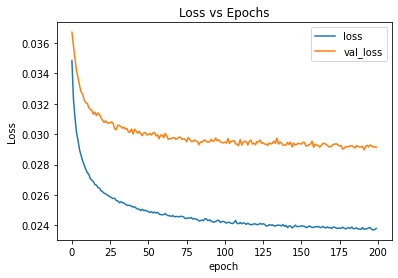

saving model at models/melody_piano.hdf5 ...
succesfully saved model !


In [61]:
train_melodyNN('piano')

# guitar melody training

loading data ...
Epoch 1/200
397/397 [==============================] - 2s 4ms/step - loss: 0.0751 - val_loss: 0.0903
Epoch 2/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0632 - val_loss: 0.0800
Epoch 3/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0576 - val_loss: 0.0769
Epoch 4/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0540 - val_loss: 0.0722
Epoch 5/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0507 - val_loss: 0.0682
Epoch 6/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0484 - val_loss: 0.0668
Epoch 7/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0462 - val_loss: 0.0649
Epoch 8/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0445 - val_loss: 0.0660
Epoch 9/200
397/397 [==============================] - 1s 3ms/step - loss: 0.0437 - val_loss: 0.0628
Epoch 10/200
397/397 [==============================] - 1s 3ms/step - loss

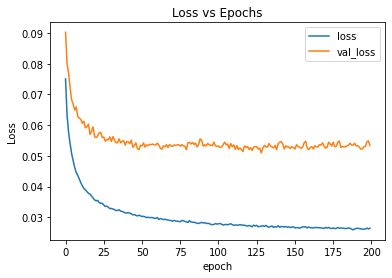

saving model at models/melody_guitar.hdf5 ...
succesfully saved model !


In [62]:
train_melodyNN('guitar')

# bass melody training

loading data ...
Epoch 1/200
1031/1031 [==============================] - 4s 4ms/step - loss: 0.0753 - val_loss: 0.0708
Epoch 2/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0676 - val_loss: 0.0681
Epoch 3/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0631 - val_loss: 0.0650
Epoch 4/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0600 - val_loss: 0.0614
Epoch 5/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0576 - val_loss: 0.0598
Epoch 6/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0559 - val_loss: 0.0578
Epoch 7/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0545 - val_loss: 0.0573
Epoch 8/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0534 - val_loss: 0.0564
Epoch 9/200
1031/1031 [==============================] - 3s 3ms/step - loss: 0.0523 - val_loss: 0.0557
Epoch 10/200
1031/1031 [==============================] 

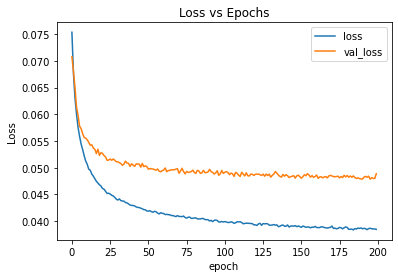

saving model at models/melody_bass.hdf5 ...
succesfully saved model !


In [63]:
train_melodyNN('bass')

# strings melody training

loading data ...
Epoch 1/200
502/502 [==============================] - 2s 4ms/step - loss: 0.0521 - val_loss: 0.0435
Epoch 2/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0455 - val_loss: 0.0404
Epoch 3/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0428 - val_loss: 0.0392
Epoch 4/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0402 - val_loss: 0.0382
Epoch 5/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0379 - val_loss: 0.0363
Epoch 6/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0365 - val_loss: 0.0351
Epoch 7/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0349 - val_loss: 0.0343
Epoch 8/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0342 - val_loss: 0.0339
Epoch 9/200
502/502 [==============================] - 2s 3ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 10/200
502/502 [==============================] - 2s 3ms/step - loss

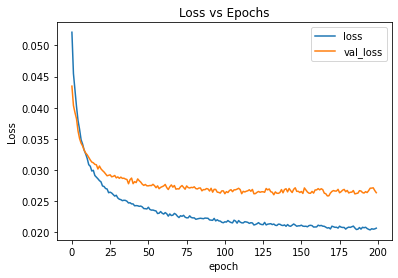

saving model at models/melody_strings.hdf5 ...
succesfully saved model !


In [64]:
train_melodyNN('strings')

# drums melody training

loading data ...
Epoch 1/200
877/877 [==============================] - 4s 4ms/step - loss: 1.1923e-05 - val_loss: 9.3193e-07
Epoch 2/200
877/877 [==============================] - 3s 3ms/step - loss: 8.3382e-07 - val_loss: 9.3562e-07
Epoch 3/200
877/877 [==============================] - 3s 3ms/step - loss: 8.3583e-07 - val_loss: 9.3756e-07
Epoch 4/200
877/877 [==============================] - 3s 3ms/step - loss: 8.3864e-07 - val_loss: 9.5511e-07
Epoch 5/200
877/877 [==============================] - 3s 3ms/step - loss: 8.4531e-07 - val_loss: 9.4171e-07
Epoch 6/200
877/877 [==============================] - 3s 3ms/step - loss: 8.4484e-07 - val_loss: 9.4771e-07
Epoch 7/200
877/877 [==============================] - 3s 3ms/step - loss: 8.4929e-07 - val_loss: 9.6774e-07
Epoch 8/200
877/877 [==============================] - 3s 3ms/step - loss: 8.4763e-07 - val_loss: 9.4964e-07
Epoch 9/200
877/877 [==============================] - 3s 3ms/step - loss: 8.5571e-07 - val_loss: 9.4948e-07
Ep

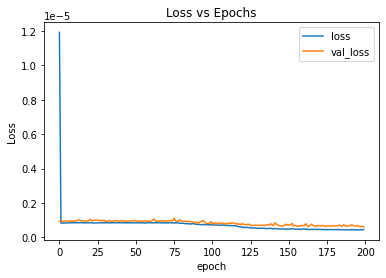

saving model at models/melody_drums.hdf5 ...
succesfully saved model !


In [65]:
train_melodyNN('drums')

# song generation

loading model piano_ae ...
succesfully loaded model !
loading model melody_piano ...
succesfully loaded model !
loading model guitar_ae ...
succesfully loaded model !
loading model melody_guitar ...
succesfully loaded model !
loading model bass_ae ...
succesfully loaded model !
loading model melody_bass ...
succesfully loaded model !
loading model strings_ae ...
succesfully loaded model !
loading model melody_strings ...
succesfully loaded model !
loading model drums_ae ...
succesfully loaded model !
loading model melody_drums ...
succesfully loaded model !


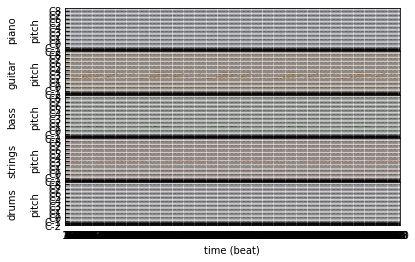

In [98]:
import pypianoroll

tracks = generate_song(['piano', 'guitar', 'bass', 'strings', 'drums'], 5)
programs = {
    'piano': 0,
    'guitar': 24,
    'bass': 32,
    'strings': 48
}
tracks_pypiano = []

for track_name, track in tracks.items():

  if track is not None: 
    
    if track_name in programs.keys():

      tracks_pypiano.append(pypianoroll.StandardTrack(name=track_name, program=programs[track_name], is_drum=False, pianoroll=track))

    else:

      tracks_pypiano.append(pypianoroll.StandardTrack(name=track_name, is_drum=True, pianoroll=track))

generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 2, tracks = tracks_pypiano)
generated_multitrack.plot()
plt.show()